In [455]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, MaxAbsScaler, Normalizer, OneHotEncoder
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, ParameterGrid
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
from sklearn.utils.class_weight import compute_class_weight
from scipy.sparse import csr_matrix
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from collections import Counter

# Section 6: Initial Model Training

We first import the CSV file and take nojte of the shape and info.
As we can see, it is a fairly large dataset with 71354 entries and 31 features with the datatypes differing between the types of variables.

In [456]:
# Load the dataset
df_nb = pd.read_csv('cleaned_df.csv')

# Display basic information about the dataset
print("Dataset Shape:", df_nb.shape)
print("Dataset Info:")
df_nb.info()

# Display the first few rows of the dataset
df_nb.head()

Dataset Shape: (71210, 30)
Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71210 entries, 0 to 71209
Data columns (total 30 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   PUFREG              71210 non-null  object 
 1   PUFURB2K10          71210 non-null  object 
 2   PUFHHSIZE           71210 non-null  int64  
 3   PUFC03_REL          71210 non-null  object 
 4   PUFC04_SEX          71210 non-null  object 
 5   PUFC05_AGE          71210 non-null  int64  
 6   PUFC06_MSTAT        71210 non-null  object 
 7   PUFC07_GRADE        71210 non-null  object 
 8   PUFC08_CURSCH       71210 non-null  object 
 9   PUFC09_GRADTECH     71210 non-null  object 
 10  PUFC10_CONWR        71210 non-null  object 
 11  PUFC11_WORK         71210 non-null  object 
 12  PUFC12_JOB          71210 non-null  object 
 13  PUFC14_PROCC        71210 non-null  object 
 14  PUFC16_PKB          71210 non-null  object 
 15  PUFC17_NATEM

,PUFREG,PUFURB2K10,PUFHHSIZE,PUFC03_REL,PUFC04_SEX,PUFC05_AGE,PUFC06_MSTAT,PUFC07_GRADE,PUFC08_CURSCH,PUFC09_GRADTECH,...,PUFC22_PFWRK,PUFC23_PCLASS,PUFC24_PBASIS,PUFC25_PBASIC,PUFC26_OJOB,PUFC28_THOURS,PUFC29_WWM48H,PUFC41_WQTR,PUFC43_QKB,PUFC16_PKB_GENERAL
0,Region I - Ilocos Region,Rural,3,Head,M,49,Married,High School Graduate,no,no,...,no,Self Employed,Monthly,0.000000,yes,3.496508,Other reasons,yes,"Crop and Animal Production, Hunting and Relate...",Agricultural
1,Region I - Ilocos Region,Rural,3,Wife/Spouse,F,61,Married,High School Graduate,no,no,...,no,Without Pay (Family Owned Business),Monthly,0.000000,no,2.197225,Other reasons,yes,"Crop and Animal Production, Hunting and Relate...",Agricultural
2,Region I - Ilocos Region,Rural,3,Son/daughter,M,19,Single,High School Graduate,no,no,...,no,Private Establishment,Per Day,5.525453,yes,3.555348,Other reasons,yes,"Crop and Animal Production, Hunting and Relate...",Agricultural
3,Region I - Ilocos Region,Rural,4,Head,M,48,Married,Second Year High School,no,no,...,no,Self Employed,Monthly,0.000000,yes,3.526361,Other reasons,yes,"Crop and Animal Production, Hunting and Relate...",Agricultural
4,Region I - Ilocos Region,Rural,4,Wife/Spouse,F,41,Married,High School Graduate,no,no,...,no,Private Household,Monthly,4.753590,no,4.290459,Requirements of the job,yes,Other Personal Service Activities,Services


To first start, we need to preprocess this model to encode the categorical data into numerical data, for this we use a simple label encoder.

In [457]:
# Encode categorical variables
categorical_cols = df_nb.select_dtypes(include=['object']).columns
for col in categorical_cols:
    le = LabelEncoder()
    df_nb[col] = le.fit_transform(df_nb[col])
    print("Original labels:", le.classes_, "\n")

    print("Mapping from nominal to numerical labels:")
    print(dict(zip(le.classes_,le.transform(le.classes_))))

Original labels: ['Autonomous Region in Muslim Mindanao' 'Cordillera Administrative Region'
 'National Capital Region' 'Region I - Ilocos Region'
 'Region II - Cagayan Valley' 'Region III - Central Luzon'
 'Region IVA - CALABARZON' 'Region IVB - MIMAROPA'
 'Region IX - Zamboanga Peninsula' 'Region V - Bicol'
 'Region VI - Western Visayas' 'Region VII - Central Visayas'
 'Region VIII - Eastern Visayas' 'Region X - Northern Mindanao'
 'Region XI - Davao' 'Region XII - SOCCSKSARGEN' 'Region XIII - Caraga'] 

Mapping from nominal to numerical labels:
{'Autonomous Region in Muslim Mindanao': 0, 'Cordillera Administrative Region': 1, 'National Capital Region': 2, 'Region I - Ilocos Region': 3, 'Region II - Cagayan Valley': 4, 'Region III - Central Luzon': 5, 'Region IVA - CALABARZON': 6, 'Region IVB - MIMAROPA': 7, 'Region IX - Zamboanga Peninsula': 8, 'Region V - Bicol': 9, 'Region VI - Western Visayas': 10, 'Region VII - Central Visayas': 11, 'Region VIII - Eastern Visayas': 12, 'Region X 

As we can see it has all been label encoded into numerical format.

In [458]:
df_nb.head()

,PUFREG,PUFURB2K10,PUFHHSIZE,PUFC03_REL,PUFC04_SEX,PUFC05_AGE,PUFC06_MSTAT,PUFC07_GRADE,PUFC08_CURSCH,PUFC09_GRADTECH,...,PUFC22_PFWRK,PUFC23_PCLASS,PUFC24_PBASIS,PUFC25_PBASIC,PUFC26_OJOB,PUFC28_THOURS,PUFC29_WWM48H,PUFC41_WQTR,PUFC43_QKB,PUFC16_PKB_GENERAL
0,3,0,3,5,1,49,2,22,0,0,...,0,4,2,0.000000,1,3.496508,2,1,13,0
1,3,0,3,10,0,61,2,22,0,0,...,0,6,2,0.000000,0,2.197225,2,1,13,0
2,3,0,3,8,1,19,3,22,0,0,...,0,2,5,5.525453,1,3.555348,2,1,13,0
3,3,0,4,5,1,48,2,37,0,0,...,0,4,2,0.000000,1,3.526361,2,1,13,0
4,3,0,4,10,0,41,2,22,0,0,...,0,3,2,4.753590,0,4.290459,3,1,57,2


Now, we want to be sure to select our target variable and features. We will use the “target” column as our target variable and the rest of the columns as features as type int, due to the fact that we have already encoded the categorical variables.

In [459]:
X = df_nb.drop(columns=['PUFC14_PROCC'])
y = df_nb['PUFC14_PROCC'].astype(int)

## Gaussian NB

We can first start training a Gaussian NB model for our classification task.

We use stratified random sampling for our test set with a test size of 30%, as our dataset is fairly large, this should be sufficient. We also shuffle the data in the process to prevent data leakage when it comes to training and testing the model.

In [460]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

In [461]:
df_gnb = GaussianNB()
df_gnb.fit(X_train, y_train)

GaussianNB()

To make sure, we print the var_smoothing variable to take note of the default value.

In [462]:
print(df_gnb.var_smoothing)

1e-09


We can first use cross validation to create more statistical measures to test the viability of our model. We then train and evaluate it. We use the functions listed:

In [463]:
def train_and_evaluate(model, X_train, X_test, y_train, y_test):
    """Train the model and compute accuracy."""
    model.fit(X_train, y_train)
    train_acc = accuracy_score(y_train, model.predict(X_train))
    test_acc = accuracy_score(y_test, model.predict(X_test))
    return train_acc, test_acc

def compute_cross_val_accuracy(model, X, y, cv=5):
    """Compute cross-validated accuracy using Stratified K-Fold."""
    stratified_kfold = StratifiedKFold(n_splits=cv, shuffle=True, random_state=1)
    scores = cross_val_score(model, X, y, cv=stratified_kfold, scoring='accuracy')
    return scores.mean(), scores.std()

In [464]:
mean_acc, std_acc = compute_cross_val_accuracy(df_gnb, X_train, y_train, cv=5)
train_acc, test_acc = train_and_evaluate(df_gnb, X_train, X_test, y_train, y_test)

In [465]:
pred_test = df_gnb.predict(X_test)
print(classification_report(y_test, pred_test))
print("mean acc:", mean_acc, "std acc:", std_acc, "train acc:", train_acc, "test acc:", test_acc)

              precision    recall  f1-score   support

           0       0.02      0.93      0.04        14
           1       0.17      0.59      0.26       619
           2       0.26      0.71      0.38       861
           3       0.85      0.12      0.21      4365
           4       0.28      0.40      0.33      1064
           5       0.41      0.56      0.48       432
           6       0.54      0.59      0.56      2037
           7       0.35      0.21      0.26      1904
           8       0.62      0.80      0.70      2393
           9       0.00      0.00      0.00       553

    accuracy                           0.40     14242
   macro avg       0.35      0.49      0.32     14242
weighted avg       0.55      0.40      0.37     14242

mean acc: 0.40176937478477504 std acc: 0.00511020536376734 train acc: 0.4009619435472546 test acc: 0.3997331835416374


As we can see, based on the metrics, our accuracy is extremely low, being under 50%. Given this result, we can test Multinomial NB models instead to see if the results improve/differ such that Naive Bayes may be applicable to our data set.

## Multinomial NB

We start training and testing our Multinomial NB model the same way we did with our Gaussian NB model, using random stratified sampling and a test set of 30%. We shuffle again to prevent data leakage and/or bias.

In [466]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

In [467]:
df_mnb = MultinomialNB()
df_mnb.fit(X_train, y_train)

MultinomialNB()

To make sure, we print the alpha variable to take note of the default value.

In [468]:
print(df_mnb.alpha)

1.0


We start computing for cross-validation accuracy, then training and testing our model.

In [469]:
mean_acc, std_acc = compute_cross_val_accuracy(df_mnb, X_train, y_train, cv=5)
train_acc, test_acc = train_and_evaluate(df_mnb, X_train, X_test, y_train, y_test)

In [470]:
pred_test = df_mnb.predict(X_test)
print(classification_report(y_test, pred_test))
print("mean acc:", mean_acc, "std acc:", std_acc, "train acc:", train_acc, "test acc:", test_acc)

              precision    recall  f1-score   support

           0       0.02      0.50      0.03        14
           1       0.18      0.17      0.18       619
           2       0.12      0.06      0.08       861
           3       0.47      0.39      0.43      4365
           4       0.43      0.44      0.44      1064
           5       0.50      0.15      0.23       432
           6       0.58      0.46      0.51      2037
           7       0.34      0.43      0.38      1904
           8       0.57      0.77      0.65      2393
           9       0.10      0.12      0.11       553

    accuracy                           0.43     14242
   macro avg       0.33      0.35      0.30     14242
weighted avg       0.43      0.43      0.42     14242

mean acc: 0.4273100538855307 std acc: 0.0022302648517894806 train acc: 0.42785423395590505 test acc: 0.42634461452043254


As we can see, the accuracy of this model is slightly more accurate than that of the Gaussian NB model we have trained.

Although this is the case, the accuracy is still lacking. So we have to check for errors in the dataset.

# Section 7: Error Analysis

To start with the error analysis to figure out why our models accuracy is so low, we start with the class counts and the class priors.

In [471]:
print(df_gnb.class_count_)
print(df_gnb.class_prior_)

[   58.  2475.  3442. 17458.  4258.  1727.  8148.  7618.  9572.  2212.]
[0.00101812 0.04344544 0.06041988 0.30645275 0.07474372 0.03031526
 0.14302766 0.1337242  0.16802415 0.03882882]


The class priors are seemingly imbalanced, with very obvious majority and minority classes which will be more evident given the following metrics:

In [472]:
# Count the occurrences of each class
class_counts = Counter(y)
print("Class Counts:", class_counts)

Class Counts: Counter({3: 21823, 8: 11965, 6: 10185, 7: 9522, 4: 5322, 2: 4303, 1: 3094, 9: 2765, 5: 2159, 0: 72})


In [473]:
# Calculate the proportion of each class
total_samples = len(y)
class_proportions = {cls: count / total_samples for cls, count in class_counts.items()}
print("Class Proportions:", class_proportions)

Class Proportions: {8: 0.16802415391096756, 3: 0.3064597668866732, 7: 0.13371717455413565, 4: 0.0747366942845106, 2: 0.060426906333380145, 6: 0.14302766465384076, 9: 0.03882881617750316, 5: 0.030318775452885832, 1: 0.04344895379862379, 0: 0.0010110939474792867}


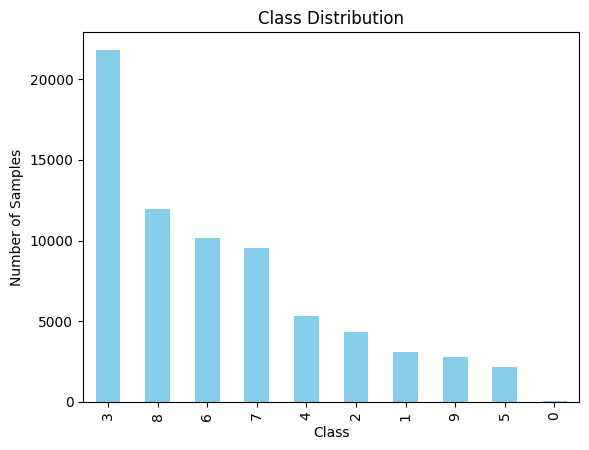

In [474]:
# Plot class distribution
class_counts = pd.Series(y).value_counts()
class_counts.plot(kind='bar', color='skyblue')
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.show()

As we can see, the class priors are extremely imbalanced, with majority classes and minority classes in the target variable (y) which in the following blocks of code, will reflect on both the testing and training set evidently.

In [475]:
# Check class distribution in training set
train_class_counts = pd.Series(y_train).value_counts()
print("Training Set Class Counts:\n", train_class_counts)

Training Set Class Counts:
 PUFC14_PROCC
3    17458
8     9572
6     8148
7     7618
4     4258
2     3442
1     2475
9     2212
5     1727
0       58
Name: count, dtype: int64


In [476]:
# Check class distribution in testing set
test_class_counts = pd.Series(y_test).value_counts()
print("Testing Set Class Counts:\n", test_class_counts)

Testing Set Class Counts:
 PUFC14_PROCC
3    4365
8    2393
6    2037
7    1904
4    1064
2     861
1     619
9     553
5     432
0      14
Name: count, dtype: int64


Given that the classes of target variable (y) are imbalanced, we also must check if any other features are highly imbalanced. We use the function listed to check for the top value proportions of these variables using a threshold of 50%, such that if the proportion exceeds the threshold, it will be listed as an imbalanced feature.

In [477]:
def find_highly_imbalanced_features(df, threshold=0.5):
    """
    Identify highly imbalanced features in a dataset.
    
    Parameters:
        df (DataFrame): The dataset.
        threshold (float): Proportion threshold to consider a feature highly imbalanced.
        
    Returns:
        imbalanced_features (list): List of tuples with feature names and their dominant proportions.
    """
    imbalanced_features = []
    
    for col in df.columns:
        # Calculate the proportion of the most frequent value
        top_value_proportion = df[col].value_counts(normalize=True).max()
        
        if top_value_proportion > threshold:
            imbalanced_features.append((col, top_value_proportion))
    
    return imbalanced_features

# Example usage
imbalanced_features = find_highly_imbalanced_features(df_nb, threshold=0.5)

# Print the results
print("Highly Imbalanced Features:")
for feature, proportion in imbalanced_features:
    print(f"{feature} is highly imbalanced ({proportion:.1%})\tImbalance")

Highly Imbalanced Features:
PUFURB2K10 is highly imbalanced (57.0%)	Imbalance
PUFC04_SEX is highly imbalanced (61.6%)	Imbalance
PUFC06_MSTAT is highly imbalanced (66.4%)	Imbalance
PUFC08_CURSCH is highly imbalanced (97.2%)	Imbalance
PUFC09_GRADTECH is highly imbalanced (94.5%)	Imbalance
PUFC10_CONWR is highly imbalanced (100.0%)	Imbalance
PUFC11_WORK is highly imbalanced (98.5%)	Imbalance
PUFC12_JOB is highly imbalanced (98.5%)	Imbalance
PUFC17_NATEM is highly imbalanced (75.5%)	Imbalance
PUFC20_PWMORE is highly imbalanced (80.4%)	Imbalance
PUFC21_PLADDW is highly imbalanced (89.5%)	Imbalance
PUFC22_PFWRK is highly imbalanced (97.9%)	Imbalance
PUFC24_PBASIS is highly imbalanced (65.9%)	Imbalance
PUFC26_OJOB is highly imbalanced (91.7%)	Imbalance
PUFC29_WWM48H is highly imbalanced (75.9%)	Imbalance
PUFC41_WQTR is highly imbalanced (97.7%)	Imbalance
PUFC16_PKB_GENERAL is highly imbalanced (55.5%)	Imbalance


Given that we now know that we have highly imbalanced variables in our dataset, we may implement methods such as changing the variable smoothing, changing the priors manually, and using SMOTE to synthetically create data to fill the features in uniformly by oversampling the minority class.

# Section 8: Improving Model Performance

Given the imbalances shown in all the previous section, we may attempt to fix this by adjusting the priors artificially to be uniform.

In [478]:
print(df_gnb.class_prior_)

[0.00101812 0.04344544 0.06041988 0.30645275 0.07474372 0.03031526
 0.14302766 0.1337242  0.16802415 0.03882882]


In [479]:
# Train and evaluate the model with adjusted priors
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

adjusted_priors = [1 / len(np.unique(y_train))] * len(np.unique(y_train))  # Uniform priors
df_gnb_adjusted = GaussianNB(priors=adjusted_priors)
mean_acc_adjusted, std_acc_adjusted = compute_cross_val_accuracy(df_gnb_adjusted, X_train, y_train, cv=5)
train_acc_adjusted, test_acc_adjusted = train_and_evaluate(df_gnb_adjusted, X_train, X_test, y_train, y_test)

print("\nAdjusted Priors:")
pred_test = df_gnb_adjusted.predict(X_test)
print(classification_report(y_test, pred_test))
print("mean acc:", mean_acc_adjusted, "std acc:", std_acc_adjusted, "train acc:", train_acc_adjusted, "test acc:", test_acc_adjusted)


Adjusted Priors:
              precision    recall  f1-score   support

           0       0.02      0.93      0.04        14
           1       0.16      0.60      0.25       619
           2       0.25      0.68      0.37       861
           3       0.86      0.10      0.18      4365
           4       0.28      0.47      0.35      1064
           5       0.38      0.62      0.47       432
           6       0.57      0.55      0.56      2037
           7       0.36      0.19      0.25      1904
           8       0.63      0.78      0.70      2393
           9       0.10      0.00      0.00       553

    accuracy                           0.39     14242
   macro avg       0.36      0.49      0.32     14242
weighted avg       0.56      0.39      0.36     14242

mean acc: 0.39150044569893705 std acc: 0.005578869224496578 train acc: 0.39144783036090436 test acc: 0.3884988063474231


In [480]:
print(df_gnb_adjusted.class_prior_)

[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


As seen, the model that was trained with adjusted priors performed worse than the model with default priors. We can train the model with the application of SMOTE to attempt to fix the class imbalances and compare a model trained with and without SMOTE applied.

In [ ]:
pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),  # Apply SMOTE
    ('classifier', GaussianNB())  # Train Naive Bayes
])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

mean_acc_smote, std_acc_smote = compute_cross_val_accuracy(pipeline, X_train, y_train, cv=5)
train_acc_smote, test_acc_smote = train_and_evaluate(pipeline, X_train, X_test, y_train, y_test)

# Evaluate the pipeline
pred_test = pipeline.predict(X_test)
print(classification_report(y_test, pred_test))
print("mean acc:", mean_acc_smote, "std acc:", std_acc_smote, "train acc:", train_acc_smote, "test acc:", test_acc_smote)

              precision    recall  f1-score   support

           0       0.02      0.86      0.04        14
           1       0.16      0.53      0.25       619
           2       0.25      0.61      0.35       861
           3       0.59      0.19      0.28      4365
           4       0.27      0.44      0.34      1064
           5       0.36      0.56      0.43       432
           6       0.60      0.47      0.53      2037
           7       0.36      0.24      0.29      1904
           8       0.63      0.75      0.69      2393
           9       0.13      0.02      0.03       553

    accuracy                           0.39     14242
   macro avg       0.34      0.47      0.32     14242
weighted avg       0.48      0.39      0.39     14242

mean acc: 0.3918691963403462 std acc: 0.0026047439556849197 train acc: 0.39237817722230023 test acc: 0.39460749894677716


As we can see, the accuracy lowered similarly when we applied SMOTE. From this, we can infer that SMOTE and uniform priors hurt thr models performance more than it does help it, as it skews the true class distribution- making all classes equally likely- which makes it more difficult for NB models to estimate correct probabilities for each class.

Given this, we can attempt to remedy class imbalance using sample weights instead. This prevents the priors from being uniform, but it assigns higher weights to minority class samples to balance their influence during the model training while still preserving a proportion of the true class priors.

In [ ]:
# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',  # Automatically balance weights
    classes=np.unique(y_train),  # Unique classes in the target
    y=y_train  # Target variable
)
# Convert to a dictionary for easy access
class_weights_dict = {cls: weight for cls, weight in zip(np.unique(y_train), class_weights)}
print("Class Weights:", class_weights_dict)

Class Weights: {0: 98.22068965517241, 1: 2.3017373737373736, 2: 1.6550842533410808, 3: 0.3263145835720014, 4: 1.337905119774542, 5: 3.2986682107701215, 6: 0.6991654393716249, 7: 0.7478078235757417, 8: 0.5951525282072712, 9: 2.5754068716094034}


In [ ]:
# Assign sample weights based on class weights
sample_weights = y_train.map(class_weights_dict)

# Fit the model with sample weights
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

weighted_gnb = GaussianNB()

In [ ]:
mean_acc_weights, std_acc_weights = compute_cross_val_accuracy(weighted_gnb, X_train, y_train, cv=5)
train_acc_weights, test_acc_weights = train_and_evaluate(weighted_gnb, X_train, X_test, y_train, y_test)

pred_test = weighted_gnb.predict(X_test)
print(classification_report(y_test, pred_test))
print("mean acc:", mean_acc_weights, "std acc:", std_acc_weights, "train acc:", train_acc_weights, "test acc:", test_acc_weights)

              precision    recall  f1-score   support

           0       0.02      0.93      0.04        14
           1       0.17      0.59      0.26       619
           2       0.26      0.71      0.38       861
           3       0.85      0.12      0.21      4365
           4       0.28      0.40      0.33      1064
           5       0.41      0.56      0.48       432
           6       0.54      0.59      0.56      2037
           7       0.35      0.21      0.26      1904
           8       0.62      0.80      0.70      2393
           9       0.00      0.00      0.00       553

    accuracy                           0.40     14242
   macro avg       0.35      0.49      0.32     14242
weighted avg       0.55      0.40      0.37     14242

mean acc: 0.40176937478477504 std acc: 0.00511020536376734 train acc: 0.4009619435472546 test acc: 0.3997331835416374


Once again, implementing sample weights has lowered the accuracy. This shows us that it is not viable to use any sort of technique that modifies class weights or priors.

We can also test MNB with SMOTE and Sample Weights

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),  # Apply SMOTE to oversample the minority class
    ('classifier', MultinomialNB())  # Train Multinomial Naive Bayes
])
pipeline.fit(X_train, y_train)

mean_acc_smote, std_acc_smote = compute_cross_val_accuracy(pipeline, X_train, y_train, cv=5)
train_acc_smote, test_acc_smote = train_and_evaluate(pipeline, X_train, X_test, y_train, y_test)

pred_test = pipeline.predict(X_test)
print(classification_report(y_test, pred_test))
print("mean acc:", mean_acc_smote, "std acc:", std_acc_smote, "train acc:", train_acc_smote, "test acc:", test_acc_smote)

              precision    recall  f1-score   support

           0       0.01      0.86      0.02        14
           1       0.26      0.23      0.24       619
           2       0.14      0.13      0.14       861
           3       0.50      0.34      0.40      4365
           4       0.38      0.49      0.43      1064
           5       0.40      0.34      0.37       432
           6       0.65      0.41      0.51      2037
           7       0.36      0.36      0.36      1904
           8       0.56      0.77      0.65      2393
           9       0.08      0.09      0.09       553

    accuracy                           0.41     14242
   macro avg       0.34      0.40      0.32     14242
weighted avg       0.45      0.41      0.42     14242

mean acc: 0.41491710594477194 std acc: 0.0015187724038289645 train acc: 0.41467139446706924 test acc: 0.4094930487291111


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',  # Automatically balance weights
    classes=np.unique(y_train),  # Unique classes in the target
    y=y_train  # Target variable
)

# Convert class weights to a dictionary
class_weights_dict = {cls: weight for cls, weight in zip(np.unique(y_train), class_weights)}

# Map sample weights based on class weights
sample_weights = y_train.map(class_weights_dict)

# Train the MultinomialNB model with sample weights
weighted_mnb = MultinomialNB(alpha=1.0)

mean_acc_weights, std_acc_weights = compute_cross_val_accuracy(weighted_mnb, X_train, y_train, cv=5)
train_acc_weights, test_acc_weights = train_and_evaluate(weighted_mnb, X_train, X_test, y_train, y_test)

pred_test = weighted_mnb.predict(X_test)
print(classification_report(y_test, pred_test))
print("mean acc:", mean_acc_weights, "std acc:", std_acc_weights, "train acc:", train_acc_weights, "test acc:", test_acc_weights)

              precision    recall  f1-score   support

           0       0.02      0.50      0.03        14
           1       0.18      0.17      0.18       619
           2       0.12      0.06      0.08       861
           3       0.47      0.39      0.43      4365
           4       0.43      0.44      0.44      1064
           5       0.50      0.15      0.23       432
           6       0.58      0.46      0.51      2037
           7       0.34      0.43      0.38      1904
           8       0.57      0.77      0.65      2393
           9       0.10      0.12      0.11       553

    accuracy                           0.43     14242
   macro avg       0.33      0.35      0.30     14242
weighted avg       0.43      0.43      0.42     14242

mean acc: 0.4273100538855307 std acc: 0.0022302648517894806 train acc: 0.42785423395590505 test acc: 0.42634461452043254


As we can see, MNB generally performs better than GNB in this model with the use of SMOTE and sample weights. We can test the different models this time with scalers.

In [ ]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

# Define pipelines for GNB and MNB with MaxAbsScaler
gnb_maxabs_pipeline = Pipeline([
    ('scaler', MaxAbsScaler()),  # Apply MaxAbs Scaling
    ('classifier', GaussianNB())  # Gaussian Naive Bayes
])

mnb_maxabs_pipeline = Pipeline([
    ('scaler', MaxAbsScaler()),  # Apply MaxAbs Scaling
    ('classifier', MultinomialNB())  # Multinomial Naive Bayes
])

# Function to train and evaluate a pipeline
def evaluate_pipeline(pipeline, X_train, X_test, y_train, y_test):
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    train_acc = pipeline.score(X_train, y_train)
    test_acc = pipeline.score(X_test, y_test)
    print(f"Train Accuracy: {train_acc:.4f}")
    print(f"Test Accuracy: {test_acc:.4f}")
    return train_acc, test_acc

# Evaluate GNB with MaxAbsScaler
print("GaussianNB with MaxAbsScaler:")
evaluate_pipeline(gnb_maxabs_pipeline, X_train, X_test, y_train, y_test)

# Evaluate MNB with MaxAbsScaler
print("\nMultinomialNB with MaxAbsScaler:")
evaluate_pipeline(mnb_maxabs_pipeline, X_train, X_test, y_train, y_test)

GaussianNB with MaxAbsScaler:
Classification Report:
              precision    recall  f1-score   support

           0       0.02      0.93      0.04        14
           1       0.17      0.59      0.26       619
           2       0.25      0.71      0.37       861
           3       0.87      0.08      0.15      4365
           4       0.28      0.40      0.33      1064
           5       0.41      0.56      0.48       432
           6       0.54      0.59      0.56      2037
           7       0.34      0.22      0.26      1904
           8       0.62      0.80      0.70      2393
           9       0.00      0.00      0.00       553

    accuracy                           0.39     14242
   macro avg       0.35      0.49      0.32     14242
weighted avg       0.55      0.39      0.35     14242

Train Accuracy: 0.3920
Test Accuracy: 0.3895

MultinomialNB with MaxAbsScaler:
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.

c:\Users\Marcus\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Marcus\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Marcus\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

(0.4302766465384075, 0.4259935402331133)

In [ ]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

# Define pipelines for GNB and MNB with MaxAbsScaler
gnb_norm_pipeline = Pipeline([
    ('scaler', Normalizer()),  # Apply Normalizer Scaling
    ('classifier', GaussianNB())  # Gaussian Naive Bayes
])

mnb_norm_pipeline = Pipeline([
    ('scaler', Normalizer()),  # Apply Normalizer Scaling
    ('classifier', MultinomialNB())  # Multinomial Naive Bayes
])

# Function to train and evaluate a pipeline
def evaluate_pipeline(pipeline, X_train, X_test, y_train, y_test):
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    train_acc = pipeline.score(X_train, y_train)
    test_acc = pipeline.score(X_test, y_test)
    print(f"Train Accuracy: {train_acc:.4f}")
    print(f"Test Accuracy: {test_acc:.4f}")
    return train_acc, test_acc

# Evaluate GNB with Normalizer
print("GaussianNB with Normalizer:")
evaluate_pipeline(gnb_norm_pipeline, X_train, X_test, y_train, y_test)

# Evaluate MNB with Normalizer
print("\nMultinomialNB with Normalizer:")
evaluate_pipeline(mnb_norm_pipeline, X_train, X_test, y_train, y_test)

GaussianNB with Normalizer:
Classification Report:
              precision    recall  f1-score   support

           0       0.02      0.93      0.05        14
           1       0.17      0.46      0.25       619
           2       0.31      0.53      0.39       861
           3       0.74      0.23      0.36      4365
           4       0.31      0.47      0.38      1064
           5       0.43      0.60      0.50       432
           6       0.44      0.66      0.53      2037
           7       0.29      0.17      0.22      1904
           8       0.66      0.77      0.71      2393
           9       0.00      0.00      0.00       553

    accuracy                           0.42     14242
   macro avg       0.34      0.48      0.34     14242
weighted avg       0.50      0.42      0.41     14242

Train Accuracy: 0.4271
Test Accuracy: 0.4244

MultinomialNB with Normalizer:
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00  

c:\Users\Marcus\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Marcus\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Marcus\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

(0.3064527454009268, 0.30648785282965874)

But we can experiment even further by changing the different hyperparameters of algorithms such as select-K-best feature selection, different scalers, alphas, and var_smoothing.

## Testing different optimizations

Instead of making the priors uniform or doing something about the distribution of classes, we may instead try using feature selection in hopes of improving the accuracy of the model.

We test different K values for select-K-best feature selection, alpha values for Multinomial NB models, and different scalers (MaxAbsScaler, and Normalizer), and var_smoothing values for GaussianNB

We can also test models with different parameter grids:
* For Multinomial NB, we define different alpha values [default = 1.0], and whether fit_prior (whether the model assumes uniform class priors, or calculates prior probabilities based on the original distribution of classes in the training data) is true or false.
* For Gaussian NB, we define var_smoothing [default = 1e-09] small values to add to the variance of each feature during the calculation of probabilities to help numerical stability with instances wherein the model has to work with divisions with zeros or numbers extremely close to zero.

We test the model using different scalers, namely MaxAbsScaler and Normalizer.
* MaxAbsScaler scales each feature by dividing it by the maximum absolute value of said feature. This will ensure that all feature variables are in range [-1, 1] while also preserving sparsity. It does nolt shift the data, making it more suitable for sparse and larger data sets (which is applicable to our dataset).
* Normalizer scales each row individually to have a unit norm (L1 or L2 norm), such that the sum of all absolute values or square root of the sum of squares of feature values will equal to 1. We use this as Gaussian NB models are assumed to work better when features are normalized to a consistent scale.

In [ ]:
# Separate features and target variable
X = df_nb.drop(columns=['PUFC14_PROCC'])
y = df_nb['PUFC14_PROCC'].astype(int)

We implement the functions listed to apply our scaling methods and feature selection method.

In [ ]:
def apply_feature_selection(X_train, X_test, y_train, k):
    """Apply SelectKBest feature selection."""
    selector = SelectKBest(mutual_info_classif, k=k)
    X_train_k = selector.fit_transform(X_train, y_train)
    X_test_k = selector.transform(X_test)
    return X_train_k, X_test_k

def apply_scaling(scaler, X_train, X_test):
    """Apply scaling (MaxAbsScaler, or Normalizer)."""
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, X_test_scaled

We start evaluating the different models.

In [ ]:
# Initialize results dictionary
results = []

# Define configurations
scalers = {
    "Max-Abs Scaling": MaxAbsScaler(),
    "Normalizer": Normalizer()
}
models = {
    "Gaussian NB": GaussianNB(),
    "Multinomial NB": MultinomialNB(),
}
# Define parameter grids for each model (ParameterGrid)
param_grids = {
    "Multinomial NB": {"alpha": [0.1, 0.5, 1.0, 1.5, 2.0], "fit_prior": [True, False]},
    "Gaussian NB": {"var_smoothing": [1e-09, 1e-08, 1e-07, 1e-06, 1e-05]}  # Parameter grid for GaussianNB
}

k_values = range(1, X_train.shape[1] + 1)  # Range of K for feature selection

# Loop through configurations
for scaler_name, scaler in scalers.items():
    for k in k_values:
        # Split the dataset into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

        # Apply feature selection
        X_train_k, X_test_k = apply_feature_selection(X_train, X_test, y_train, k)

        # Apply the scaler
        X_train_k = scaler.fit_transform(X_train_k)
        X_test_k = scaler.transform(X_test_k)

        # Convert to sparse matrices if needed
        X_train_k = csr_matrix(X_train_k)
        X_test_k = csr_matrix(X_test_k)

        for model_name, model in models.items():
            if model_name == "Multinomial NB":
                # Multinomial NB models with different alpha values or parameter grids
                param_grid = param_grids[model_name]
                for params in ParameterGrid(param_grid):
                    model.set_params(**params)

                    # Compute cross-validation metrics
                    mean_acc, std_acc = compute_cross_val_accuracy(model, X_train_k, y_train, cv=5)

                    # Compute train and test accuracy
                    train_acc, test_acc = train_and_evaluate(model, X_train_k, X_test_k, y_train, y_test)

                    results.append({
                        "Model": f"{model_name} + Select-K-Best (K={k}) + Params={params} + Scaler={scaler_name}",
                        "Mean CV Accuracy": mean_acc,
                        "Std CV Accuracy": std_acc,
                        "Train Accuracy": train_acc,
                        "Test Accuracy": test_acc
                    })

            else:
                # Gaussian NB with ParameterGrid
                param_grid = param_grids[model_name]
                for params in ParameterGrid(param_grid):
                    model.set_params(**params)

                    # Compute cross-validation metrics
                    mean_acc, std_acc = compute_cross_val_accuracy(model, X_train_k.toarray(), y_train, cv=5)

                    # Compute train and test accuracy
                    train_acc, test_acc = train_and_evaluate(model, X_train_k.toarray(), X_test_k.toarray(), y_train, y_test)

                    results.append({
                        "Model": f"{model_name} + Select-K-Best (K={k}) + Params={params} + Scaler={scaler_name}",
                        "Mean CV Accuracy": mean_acc,
                        "Std CV Accuracy": std_acc,
                        "Train Accuracy": train_acc,
                        "Test Accuracy": test_acc
                    })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Display results
print(results_df)

# Find the best model based on Mean CV Accuracy
best_model = results_df.loc[results_df['Mean CV Accuracy'].idxmax()]
print(f"\nBest Model using Label Encoder: {best_model['Model']}")
print(f"Mean CV Accuracy: {best_model['Mean CV Accuracy']}")
print(f"Std CV Accuracy: {best_model['Std CV Accuracy']}")
print(f"Train Accuracy: {best_model['Train Accuracy']}")
print(f"Test Accuracy: {best_model['Test Accuracy']}")

KeyboardInterrupt: 

Our best model is using Gaussian NB using a Normalizer Scaler, with a K value of 17 for select-K-best feature selection, and a var_smoothing of 1e-06

We have only experimented so far on the model using a Label Encoder to convert the nominal labels into numerical ones.

We can test the models again, with the same iterative method but this time using one-hot-encoding to convert the nominal labels into numerical ones.

In [ ]:
# Load the dataset
df_nb_ohe = pd.read_csv('cleaned_df.csv')

In [ ]:
# Encode categorical variables using OneHotEncoder
categorical_cols = df_nb.select_dtypes(include=['object']).columns
one_hot_encoder = OneHotEncoder(sparse_output=False)

# Apply one-hot encoding
df_one_hot = pd.DataFrame(one_hot_encoder.fit_transform(df_nb_ohe[categorical_cols]),
                          columns=one_hot_encoder.get_feature_names_out(categorical_cols))

# Drop original categorical columns and concatenate one-hot encoded columns
df_nb_ohe = df_nb_ohe.drop(columns=categorical_cols).reset_index(drop=True)
df_nb_ohe = pd.concat([df_nb, df_one_hot], axis=1)

In [ ]:
# Separate features and target variable
X = df_nb_ohe.drop(columns=['PUFC14_PROCC'])  
y = df_nb_ohe['PUFC14_PROCC'].astype(int)

In [ ]:
# Initialize results dictionary
results = []

# Define configurations
scalers = {
    "Max-Abs Scaling": MaxAbsScaler(),
    "Normalizer": Normalizer()
}
models = {
    "Gaussian NB": GaussianNB(),
    "Multinomial NB": MultinomialNB(),
}
# Define parameter grids for each model (ParameterGrid)
param_grids = {
    "Multinomial NB": {"alpha": [0.1, 0.5, 1.0, 1.5, 2.0], "fit_prior": [True, False]},
    "Gaussian NB": {"var_smoothing": [1e-09, 1e-08, 1e-07, 1e-06, 1e-05]}  # Parameter grid for GaussianNB
}

k_values = range(1, X_train.shape[1] + 1)  # Range of K for feature selection

# Loop through configurations
for scaler_name, scaler in scalers.items():
    for k in k_values:
        # Split the dataset into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

        # Apply feature selection
        X_train_k, X_test_k = apply_feature_selection(X_train, X_test, y_train, k)

        # Apply the scaler
        X_train_k = scaler.fit_transform(X_train_k)
        X_test_k = scaler.transform(X_test_k)

        # Convert to sparse matrices if needed
        X_train_k = csr_matrix(X_train_k)
        X_test_k = csr_matrix(X_test_k)

        for model_name, model in models.items():
            if model_name == "Multinomial NB":
                # Multinomial NB models with different alpha values or parameter grids
                param_grid = param_grids[model_name]
                for params in ParameterGrid(param_grid):
                    model.set_params(**params)

                    # Compute cross-validation metrics
                    mean_acc, std_acc = compute_cross_val_accuracy(model, X_train_k, y_train, cv=5)

                    # Compute train and test accuracy
                    train_acc, test_acc = train_and_evaluate(model, X_train_k, X_test_k, y_train, y_test)

                    results.append({
                        "Model": f"{model_name} + Select-K-Best (K={k}) + Params={params} + Scaler={scaler_name}",
                        "Mean CV Accuracy": mean_acc,
                        "Std CV Accuracy": std_acc,
                        "Train Accuracy": train_acc,
                        "Test Accuracy": test_acc
                    })

            else:
                # Gaussian NB with ParameterGrid
                param_grid = param_grids[model_name]
                for params in ParameterGrid(param_grid):
                    model.set_params(**params)

                    # Compute cross-validation metrics
                    mean_acc, std_acc = compute_cross_val_accuracy(model, X_train_k.toarray(), y_train, cv=5)

                    # Compute train and test accuracy
                    train_acc, test_acc = train_and_evaluate(model, X_train_k.toarray(), X_test_k.toarray(), y_train, y_test)

                    results.append({
                        "Model": f"{model_name} + Select-K-Best (K={k}) + Params={params} + Scaler={scaler_name}",
                        "Mean CV Accuracy": mean_acc,
                        "Std CV Accuracy": std_acc,
                        "Train Accuracy": train_acc,
                        "Test Accuracy": test_acc
                    })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Display results
print(results_df)

# Find the best model based on Mean CV Accuracy
best_model = results_df.loc[results_df['Mean CV Accuracy'].idxmax()]
print(f"\nBest Model using Label Encoder: {best_model['Model']}")
print(f"Mean CV Accuracy: {best_model['Mean CV Accuracy']}")
print(f"Std CV Accuracy: {best_model['Std CV Accuracy']}")
print(f"Train Accuracy: {best_model['Train Accuracy']}")
print(f"Test Accuracy: {best_model['Test Accuracy']}")

                                                 Model  Mean CV Accuracy  \
0    Gaussian NB + Select-K-Best (K=1) + Params={'v...          0.345246   
1    Gaussian NB + Select-K-Best (K=1) + Params={'v...          0.345246   
2    Gaussian NB + Select-K-Best (K=1) + Params={'v...          0.345246   
3    Gaussian NB + Select-K-Best (K=1) + Params={'v...          0.345246   
4    Gaussian NB + Select-K-Best (K=1) + Params={'v...          0.345246   
..                                                 ...               ...   
865  Multinomial NB + Select-K-Best (K=29) + Params...          0.404385   
866  Multinomial NB + Select-K-Best (K=29) + Params...          0.306453   
867  Multinomial NB + Select-K-Best (K=29) + Params...          0.404420   
868  Multinomial NB + Select-K-Best (K=29) + Params...          0.306453   
869  Multinomial NB + Select-K-Best (K=29) + Params...          0.403964   

     Std CV Accuracy  Train Accuracy  Test Accuracy  
0           0.003741        0.346

As we can see, despite using a different encoding method, the results still seem to be similar to that of label encoded models.
The best model parameters for one hot encoded models have also not differed from that of the label encoded models.

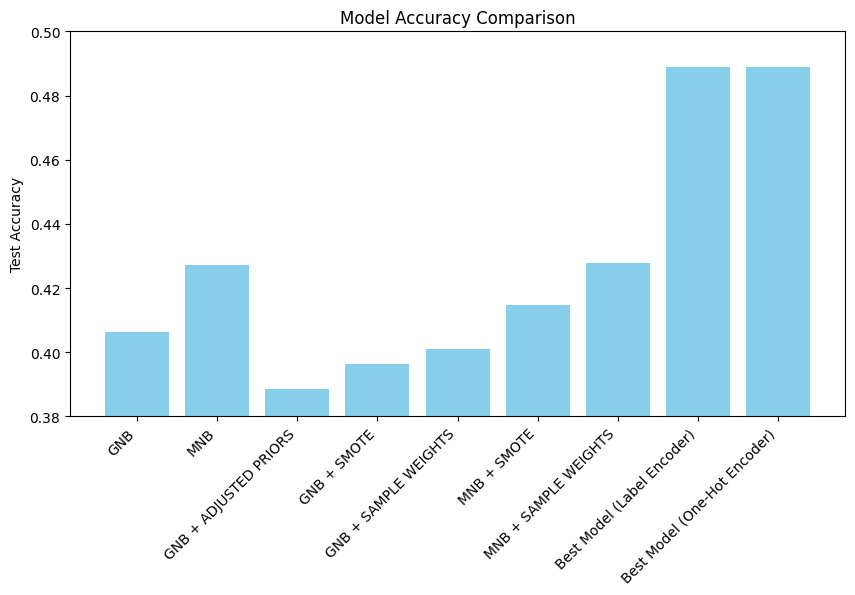

In [ ]:
models = ["GNB", "MNB", "GNB + ADJUSTED PRIORS", "GNB + SMOTE", "GNB + SAMPLE WEIGHTS", 
          "MNB + SMOTE", "MNB + SAMPLE WEIGHTS", "Best Model (Label Encoder)", "Best Model (One-Hot Encoder)"]

accuracies = [0.4064, 0.4273, 0.3885, 0.3965, 0.4010, 0.4147, 0.4279, 0.4890, 0.4890]

# Plot Accuracy
plt.figure(figsize=(10,5))
plt.bar(models, accuracies, color='skyblue')
plt.ylabel("Test Accuracy")
plt.title("Model Accuracy Comparison")
plt.ylim(0.38, 0.5)
plt.xticks(rotation=45, ha='right')
plt.show()